# Importing packages

In [2]:
''' GENERAL '''
import pandas as pd
import numpy as np

''' PLOTS '''
import seaborn as sns
import matplotlib.pyplot as plt

''' STATISTICS '''
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test

In [3]:
# Write latex table from pandas df
def write_table(table, name, caption, label, dec=None, sig_note=False, index=True):
    if dec:
        dec = f'%.{dec}f'

    # Get latex
    table_latex = table.to_latex(caption=caption, label='tab:' + label, float_format=dec, index=index)
    # Center table
    table_latex = table_latex.replace('\\begin{table}\n', '\\begin{table}\n\\centering\n')

    # Note with critical values
    sig_note_str = '''\\bottomrule
\\addlinespace[1ex]
\\multicolumn{3}{l}
    {
        \\textsuperscript{***}$p<0.01$,
        \\textsuperscript{**}$p<0.05$,
        \\textsuperscript{*}$p<0.1$
    }'''

    # Add note to table
    if sig_note:
        table_latex = table_latex.replace('\\bottomrule', sig_note_str)

    # Write to files
    with open(f'tables/{name}.tex', 'w') as out:
        out.write(table_latex)

    print(table_latex)

In [4]:
# Add significance to values
def add_sigs(val):
    if val <= 0.01:
        return str(val) + '***'
    elif 0.01 < val <= 0.05:
        return str(val) + '**'
    elif 0.05 < val <= 0.1:
        return str(val) + '*'
    else:
        return str(val)


# Preparation

In [6]:
''' SIMILAR OCCUPATION COUNTS '''

sim_occ = pd.read_csv('sim_occ_level_3.csv', dtype={'sim_occ': 'str'})
counts_long = pd.DataFrame(sim_occ.groupby('app_year', as_index=False)['sim_occ'].value_counts())

def rel_count(row, nr_patents):
    count = row['count']
    year = row['app_year']
    total = nr_patents.loc[nr_patents['app_year'] == year, 'count'].iloc[0]

    return (count / total) * 100

patents_per_year = pd.DataFrame(sim_occ['app_year'].value_counts())
patents_per_year = patents_per_year.sort_values('app_year', axis=0).reset_index()

counts_long['count_rel'] = counts_long.apply(lambda x: rel_count(x, patents_per_year), axis=1)

counts_wide = counts_long.query("2009 <= app_year <= 2020")
counts_wide = counts_wide.pivot(columns='sim_occ', index='app_year', values='count')
counts_wide.columns.name = None
counts_wide.index.name = None
counts_wide = counts_wide.fillna(0)
counts_wide = counts_wide.astype('int')

FileNotFoundError: [Errno 2] No such file or directory: 'final_files/sim_occ_level_3.csv'

In [7]:
''' LABOR FORCE SURVEY '''
# Labour force survey
lfs_long = pd.read_csv('lfs.csv', dtype={'ISCO3D': 'str'})
lfs_long.rename({'nuts': 'nuts_code', 'ISCO3D': 'isco_code', 'NACE1D': 'nace_code'}, axis=1, inplace=True)

lfs_long['nuts_code'] = lfs_long['nuts_code'].apply(lambda x: x[:2])
lfs_long = lfs_long.groupby(['nuts_code', 'year', 'isco_code'], as_index=False)['n'].sum()

# Add 0 to military isco codes: "21" --> "021"
lfs_long['isco_code'] = np.select(
    condlist=[
        lfs_long['isco_code'].apply(lambda x: len(x) == 2),
        lfs_long['isco_code'].apply(lambda x: len(x) == 1)
    ],
    choicelist=[
        lfs_long['isco_code'].apply(lambda x: '0' + x),
        lfs_long['isco_code'].apply(lambda x: '00' + x),
    ],
    default=lfs_long['isco_code']
)
lfs_long.set_index(['nuts_code', 'year'], inplace=True)


''' pivot '''

lfs_wide = lfs_long.pivot_table(index=['nuts_code', 'year'], columns='isco_code', values='n')
lfs_wide = lfs_wide.fillna(0)
lfs_wide =  lfs_wide.astype('int')

lfs_wide = lfs_wide.reset_index()
lfs_wide.set_index(['nuts_code', 'year'], inplace=True)
lfs_wide.columns.name = None

lfs_wide = lfs_wide.drop(columns=[c for c in lfs_wide.columns if not c in counts_wide.columns])

''' aggregated '''

lfs_wide_eu = lfs_wide.groupby('year').mean()
lfs_wide_eu['nuts_code'] = 'EU'
lfs_wide_eu =lfs_wide_eu.set_index('nuts_code', append=True)
lfs_wide_eu = lfs_wide_eu.reorder_levels(['nuts_code', 'year'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/labourmarket/lfs.csv'

In [8]:
''' PATENT TECH SECTOR '''

tech_specs = pd.read_csv('data/patents/patent_tech.tsv', sep='\t')
patents = pd.read_csv('data/patents/sustainability_patents.tsv', sep='\t')

tech_specs = pd.DataFrame(tech_specs.groupby('appln_id', as_index=False)['cpc'].agg(tuple))
tech_specs = tech_specs.merge(patents[['pub_nbr', 'appln_id']], on='appln_id').reset_index(drop=True).reindex(columns=['pub_nbr', 'cpc'])

sim_occ = sim_occ.merge(tech_specs, on='pub_nbr', how='left')

FileNotFoundError: [Errno 2] No such file or directory: 'data/patents/patent_tech.tsv'

In [9]:
''' ISCO DESCRIPTIONS '''

isco_descriptions = pd.read_csv('isco.csv', dtype={'isco_code': 'str'})
isco_descriptions = isco_descriptions.set_index('isco_code').drop(columns='isco_level')

FileNotFoundError: [Errno 2] No such file or directory: 'data/dfs/isco.csv'

# Descriptive

In [10]:
''' ADFULLER '''

adfuller_dict = {}
isco_codes = counts_wide.columns
nr_errors = 0
error_dict = {}

for c in isco_codes:
    df_sub = counts_wide[c]

    try:
        result = adfuller(df_sub)
        adfuller_dict[c] = result

    except Exception as e:
        nr_errors += 1
        error_dict[c] = e
        adfuller_dict[c] = np.nan


adfuller_result = pd.DataFrame.from_dict(adfuller_dict, orient='index').reset_index()
adfuller_result[1] = adfuller_result[1].apply(lambda x: round(x, 4) if not isinstance(x, str) else x)
adfuller_result = adfuller_result.reindex(['index', 1],axis=1).rename(columns={'index': 'ISCO Code', 1: 'ADF p-value'})
adfuller_result = adfuller_result.sort_values('ISCO Code')
adfuller_result.reset_index(drop=True, inplace=True)

NameError: name 'counts_wide' is not defined

In [ ]:
''' TOTAL TECH SPEC COUNT '''

tech_specs_total = pd.read_csv('data/patents/patent_tech.tsv', sep='\t')
tech_specs_total = tech_specs_total[tech_specs_total['appln_id'].isin(patents['appln_id'])]
tech_specs_total = tech_specs_total['cpc'].value_counts().reset_index()
tech_specs_total['count_rel'] = tech_specs_total['count'].apply(lambda x: f"{round((x/tech_specs_total['count'].sum()*100), 2)}\%")
tech_specs_total.columns = ['Technical specification', 'Count', 'Relative count']
tech_specs_total= tech_specs_total.drop(tech_specs_total.iloc[-2:].index)

tech_strs = {
    '10/1': 'Geothermal',
    '10/2': 'Hydro',
    '10/3': 'Ocean',
    '10/4': 'Solar thermal',
    '10/5': 'Solar PV',
    '10/6': 'Solar thermal-PV',
    '10/7': 'Wind',
    '50/1': 'Biofuel',
}

tech_specs_total = tech_specs_total.replace(tech_strs)

write_table(tech_specs_total, 'tech_specs_total', 'Technical specification, total counts', 'tech_specs_total', index=False, dec=2)

In [18]:
# Table with most common level 3 ISCO occupations

len_sim_occ_overall = len(sim_occ)
sim_occ_overall = sim_occ['sim_occ'].value_counts().reset_index()
sim_occ_overall['rel_count'] = sim_occ_overall['count'].apply(lambda x: f'{round(((x / len_sim_occ_overall) * 100), 2)}%')
sim_occ_overall = sim_occ_overall.merge(isco_descriptions.reset_index()[['isco_code', 'isco_title']], left_on='sim_occ', right_on='isco_code').drop(columns='isco_code')
write_table(sim_occ_overall.iloc[:10], 'overall_dist', 'Total occupation counts', 'overall_dist', index=False)

In [23]:
# Big ADF table

adf_dict = {}
isco_codes = counts_long['sim_occ'].unique()

for c in isco_codes:
    df_sub = counts_long[counts_long['sim_occ'] == c]
    try:
        result = adfuller(df_sub['count'])
        adf_dict[c] = result
    except Exception as e:
        adf_dict[c] = np.nan

adf_results = pd.DataFrame.from_dict(adf_dict, orient='index').reset_index()
adf_results[1] = adf_results[1].apply(lambda x: round(x, 4) if not isinstance(x, str) else x)
adf_results = adf_results.reindex(['index', 1], axis=1).rename(columns={'index': 'ISCO Code', 1: 'ADF p-value'})
adf_results = adf_results.sort_values('ISCO Code')
adf_results.reset_index(drop=True, inplace=True)
adf_results.to_csv('data/out/adf_res3.csv')
print('na', len(adf_results[adf_results['ADF p-value'].isna()]))
print('sig', len(adf_results[adf_results['ADF p-value'] <= .1]))
print('insig', len(adf_results[adf_results['ADF p-value'] > .1]))

adf_results['n'] = adf_results['ISCO Code'].apply(lambda x: counts_long[counts_long['sim_occ'] == x]['count'].sum())
adf_results['n'] = adf_results['n'].astype('str')
adf_results = adf_results.reindex(columns=['ISCO Code', 'n', 'ADF p-value'])
adf_results.loc[:, 'ADF p-value'] = adf_results['ADF p-value'].apply(add_sigs)

adf1 = adf_results.iloc[:32]
adf1.reset_index(drop=True, inplace=True)
adf2 = adf_results.iloc[32:64]
adf2.reset_index(drop=True, inplace=True)
adf3 = adf_results.iloc[64:96]
adf3.reset_index(drop=True, inplace=True)

adf_concat = pd.concat([adf1, adf2, adf3], axis='columns')

write_table(adf_concat, 'adf_concat', 'Stationarity analysis (ISCO Level 3)', 'stat_results', dec=4, sig_note=True, index=False)

na 26
sig 21
insig 48


/Users/niekprivate/.pyenv/versions/3.11.4/envs/thesis/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/var/folders/59/3fvzp2c90sn26xfms13sd5l00000gp/T/ipykernel_19312/2717807272.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['nan' 'nan' '0.9901' 'nan' 'nan' 'nan' 'nan' 'nan' '0.4317' '0.586'
 '0.0195**' 'nan' '0.3828' 'nan' '0.4147' '0.0***' '0.0017***' 'nan' 'nan'
 '0.2344' '0.7868' 'nan' 'nan' '0.3016' '0.2437' '0.3944' '0.9249' 'nan'
 '0.0543*' '0.0085***' '0.5513' '0.3369' '0.9959' '0.0176**' 'nan' 'nan'
 'nan' '0.0474**' '0.0158**' '0.4703' 'nan' '0.0104**' '0.3313' '0.0459**'
 '0.1934' '0.3351' '0.4659' 'nan' 'nan' '0.498' '0.2305' '0.8355' '0.0***'
 '0.2124' '0.0***' '0.0001***' 'nan' '0.7577' '0.2866' '0.1726' '0.5128'
 '0.0413**' '0.4815' '0.7244' '0.4659' '0.4

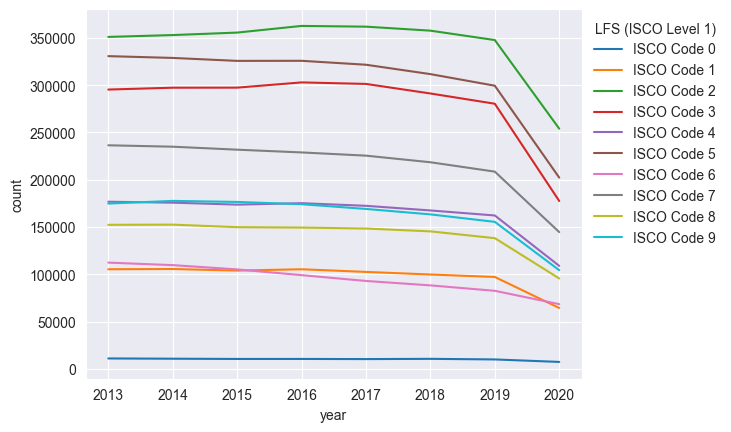

In [29]:
lfs_grouper = lfs_long.reset_index().groupby(['year', 'isco_code'], as_index=False)['n'].sum()
lfs_grouper['isco_code_1'] = lfs_grouper['isco_code'].apply(lambda x: x[0])
lfs_grouper[lfs_grouper['isco_code_1'] == '2'].groupby('year')['n'].sum()

for i in range(10):
    sub = lfs_grouper[lfs_grouper['isco_code_1'] == str(i)].groupby('year')['n'].sum()
    sub.name = 'count'
    sns.lineplot(sub, label=f'ISCO Code {i}')

plt.legend(title='LFS (ISCO Level 1)', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)

plt.savefig('figs/lfs_isco_distr', bbox_inches='tight')